In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Loading the older catalog. 

In [3]:
pd.set_option('display.max_columns', None)
cat_all_old = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat_old = cat_all_old.copy()
cat_old

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Loading the newer catalog. 

In [4]:
pd.set_option('display.max_columns', None)
cat_all_new = pd.read_csv('../../src/IRIS_DMC_esecEventsDb_updated.txt', sep='|')
cat_new = cat_all_new.copy()
cat_new

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.07970,0.00,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
2,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
3,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
4,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.70900,0.10,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.67530,-62.17620,16.70900,-62.17620,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3500000.0,NaN,NaN,NaN,275,IRIS,NaN,2009_08_10 110853,275,1500.0,NaN,NaN,NaN,NaN,NaN,7200.0,7500.0,7000.0,23.22810,0.00,120.75170,1,NaN,NaN,NaN,NaN,NaN,208.0,True,NaN,NaN,277.0,False,NaN,NaN,NaN,"Butangbunasi, Taiwan",5,NaN,NaN,NaN,NaN,NaN,NaN,2009_08_10 110556,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",23.18310,120.77820,23.22810,120.75170,NaN,landslide,Rock/ice/debris avalanches and slides,83800000.0,NaN,NaN
315,NaN,NaN,NaN,NaN,319,"NCEDC, IRIS",NaN,2022_08_03 032337,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.39070,1.00,-122.18550,0,NaN,NaN,NaN,0.0,NaN,14.0,False,NaN,NaN,0.0,NaN,NaN,NaN,False,"Mud Creek, Mount Shasta",3,NaN,NaN,NaN,NaN,NaN,NaN,2022_08_03 012901,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
316,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,1600.0,NaN,NaN,NaN,7600.0,7900.0,7300.0,51.87130,0.00,-125.94340

## Testing the retrained models on new events

In [5]:
cat_test = cat_new.merge(
    cat_old.drop_duplicates(),        # just in case cat_old has duplicates
    how="left",
    indicator=True
).query('_merge == "left_only"') \
  .drop(columns='_merge')             # (_merge was just for filtering)



# 1️⃣  Build the sets once
ids_test = set(cat_test['eventid'])
ids_old  = set(cat_old['eventid'])

# 2️⃣  Find and display every overlapping ID
overlap = ids_test & ids_old
print(f"🔍  Overlap count: {len(overlap)}")
if overlap:
    print("Overlapping eventid(s):", sorted(overlap))

# 3️⃣  Option A – DROP the overlaps from cat_test
cat_test_clean = cat_test[~cat_test['eventid'].isin(overlap)].copy()

# ───────────────────────────────────────────────────────────────
# If you’d rather regenerate your split instead of dropping, do it
# here (e.g. re-sample from cat_new after excluding cat_old).
# ───────────────────────────────────────────────────────────────

# 4️⃣  Final safety check
assert not cat_test_clean['eventid'].isin(cat_old['eventid']).any(), \
       "Overlap still present!"

print("✅  cat_test is now disjoint from cat_old.")

cat = cat_test_clean.copy()

🔍  Overlap count: 6
Overlapping eventid(s): [4, 23, 59, 81, 166, 192]
✅  cat_test is now disjoint from cat_old.


In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [8]:
cat['starttime']

1      2017_06_23 213916
4      1997_12_26 070240
6      2013_01_21 010828
18     2020_07_24 214125
28     2021_07_27 172215
             ...        
296    2022_09_01 204553
306    2023_09_16 123545
312    2022_09_01 205421
314    2009_08_10 110556
315    2022_08_03 012901
Name: starttime, Length: 74, dtype: object

In [9]:
cat = cat.reset_index(drop = True)
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [10]:
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.0797,0.0,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
1,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.7090,0.1,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.6753,-62.1762,16.7090,-62.1762,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
2,NaN,NaN,NaN,NaN,277,IRIS,NaN,2013_01_21 011052,277,900.0,NaN,NaN,NaN,NaN,NaN,2900.0,NaN,NaN,-43.5611,0.0,170.18010,2,NaN,NaN,NaN,NaN,NaN,73.0,False,NaN,NaN,56.0,False,NaN,NaN,NaN,"Mount Haast, New Zealand",5,NaN,NaN,NaN,NaN,NaN,NaN,2013_01_21 010828,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",-43.5857,170.1764,-43.5611,170.1801,NaN,rock avalanche,Rock/ice/debris avalanches and slides,2000000.0,NaN,NaN
3,NaN,NaN,NaN,NaN,276,IRIS,NaN,2020_07_24 221811,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.2600,0.0,-111.62292,0,NaN,NaN,NaN,2.0,1.0,2.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Museum Fire, Arizona",5,NaN,3.0,6.0,NaN,NaN,NaN,2020_07_24 214125,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,280,"NCEDC, IRIS",NaN,2021_07_28 025915,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.4197,0.6,-122.21150,0,NaN,NaN,NaN,9.0,1.0,9.0,True,NaN,NaN,0.0,NaN,0.0,NaN,NaN,"Whitney and Bolam Creek, Mount Shasta",4,NaN,NaN,NaN,NaN,NaN,NaN,2021_07_27 172215,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,NaN,NaN,NaN,NaN,296,IRIS,NaN,2022_09_01 204705,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.1985,0.4,-122.17590,0,NaN,NaN,NaN,NaN,NaN,4.0,True,NaN,NaN,0.0,NaN,NaN,NaN,False,Mount St Helens 1,1,NaN,NaN,NaN,NaN,NaN,NaN,2022_09_01 204553,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,rock fall,Rock/debris falls,NaN,NaN,NaN
70,160000.0,NaN,NaN,NaN,322,"IRIS, GEOFON",NaN,2023_09_16 124211,322,350.0,400.0,300.0,NaN,NaN,NaN,2200.0,NaN,1600.0,72.8080,0.0,-26.94400,1,5.500000e+10,1.030000e+11,NaN,NaN,NaN,957.0,False,NaN,NaN,957.0,False,3310.0,False,True,"Dickson Fjord, Greenland",5,NaN,NaN,NaN,NaN,NaN,NaN,2023_09_16 123545,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock and ice avalanche",Rock/ice/debris avalanches and slides,25500000.0,27500000.0,23800000.0
71,NaN,NaN,NaN,NaN,297,IRIS,NaN,2022_09_01 205627,297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2049,0.4,-122.17420,0,NaN,NaN,NaN,NaN,NaN,5.0,True,NaN,NaN,0.0,NaN,NaN,NaN,False,Mount St Helens 2,1,NaN,NaN,NaN,NaN,NaN,NaN,2022_09_01 205421,"Collins, E.A., Allstadt, K.E., Groul

## Testing the models on the saved data

(270s in total, 70s before and 200s after the starttime of the event). 

In [11]:
# ── 1. load every model you need ────────────────────────────────────────────
models = {
    "m2": sbm.SeismicCNN.from_pretrained("base",  version_str="2"),
    "m3": sbm.SeismicCNN.from_pretrained("base",  version_str="3"),
}

# ── 2. nested dict:  {(event, station): {model_name: probs}}
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*")

    # unique station codes in this event directory
    station_codes = {
        re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name).group(1)
        for f in file_list
        if re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name)
    }

    for stn in sorted(station_codes):
        chn_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*")

        if len(chn_list) != 3:          # need exactly Z/N/E
            continue

        try:
            st = obspy.Stream()
            for chn in chn_list:
                st += obspy.read(chn)
            st.sort(["channel"])

            # annotate with every model and store under its name
            for name, mdl in models.items():
                probs = np.asarray(mdl.annotate(st, stride = 1000))          # (n_classes, n_windows)
                probs_global.setdefault((event_id, stn), {})[name] = probs

        except Exception as e:
            print(f"[{event_id} | {stn}] → {e}")


  8%|▊         | 6/74 [00:45<08:32,  7.54s/it]
Exception ignored in: <function tqdm.__del__ at 0x7fda45011820>
Traceback (most recent call last):
  File "/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/tqdm/std.py", line 1144, in __del__
KeyboardInterrupt: 

KeyboardInterrupt



## Computing the probabilities

In [31]:
CLASS_IDX   = {"eq": 0, "px": 1, "noise": 2, "surface": 3}
PRIORITY    = ["eq", "px", "surface"]     # which classes can be the “winner”
MODELS_USED = ["m2", "m3"]                # adapt if you add more

def _winner_label(class_probs, thr):
    """Return label string given a dict {cls:prob}."""
    # consider only eq, px, surface for max decision
    max_cls = max(PRIORITY, key=lambda c: class_probs[c])
    return max_cls if class_probs[max_cls] > thr else "noise"

def process_probabilities(probs_dict, threshold=0.5):
    rows = []

    for (event_id, station), model_dict in probs_dict.items():
        row            = {"event_id": event_id, "station": station}
        ensemble_store = {cls: [] for cls in CLASS_IDX}   # collect per-model max

        # ── per-model columns ───────────────────────────────────────────
        for mdl_name in MODELS_USED:
            if mdl_name not in model_dict:
                continue                                  # skip missing model

            probs = model_dict[mdl_name]
            if probs.shape[0] > 4:                       # transpose if needed
                probs = probs.T

            # max over windows
            cls_max = {
                "eq"     : probs[CLASS_IDX["eq"]    ].mean(),
                "px"     : probs[CLASS_IDX["px"]    ].mean(),
                "noise"  : probs[CLASS_IDX["noise"] ].mean(),
                "surface": probs[CLASS_IDX["surface"]].mean(),
            }

            # add to row
            row[f"prob_eq_{mdl_name}"]  = cls_max["eq"]
            row[f"prob_px_{mdl_name}"]  = cls_max["px"]
            row[f"prob_noise_{mdl_name}"]  = cls_max["noise"]
            row[f"prob_surface_{mdl_name}"]  = cls_max["surface"]
            
            row[f"max_prob_{mdl_name}"] = max(cls_max[c] for c in PRIORITY)
            row[f"assigned_label_{mdl_name}"] = _winner_label(cls_max, threshold)

            # accumulate for ensemble
            for cls, val in cls_max.items():
                ensemble_store[cls].append(val)

        # ── ensemble mean columns ───────────────────────────────────────
        ens_mean = {cls: float(np.mean(vals)) for cls, vals in ensemble_store.items()}
        row["prob_eq_ens"]     = ens_mean["eq"]
        row["prob_px_ens"]     = ens_mean["px"]
        row["prob_noise_ens"]  = ens_mean["noise"]
        row["prob_surface_ens"]= ens_mean["surface"]
        row["max_prob_ens"]    = max(ens_mean[c] for c in PRIORITY)
        row["assigned_label_ens"] = _winner_label(ens_mean, threshold)

        rows.append(row)

    return pd.DataFrame(rows)


In [32]:
labels_df = process_probabilities(probs_global, threshold = 0.1)

In [33]:
labels_df

,event_id,station,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,max_prob_m3,assigned_label_m3,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens
0,276,BABIT,0.076217,0.031626,0.770184,1.219729e-01,0.121973,surface,0.056763,0.165300,0.501111,0.276826,0.276826,surface,0.066490,0.098463,0.635647,0.199399,0.199399,surface
1,276,BARN,0.027325,0.025610,0.924827,2.223815e-02,0.027325,noise,0.146332,0.244793,0.439926,0.168950,0.244793,px,0.086829,0.135201,0.682376,0.095594,0.135201,px
2,276,LG2B,0.101633,0.005865,0.575665,3.168373e-01,0.316837,surface,0.303296,0.111114,0.468213,0.117377,0.303296,eq,0.202465,0.058490,0.521939,0.217107,0.217107,surface
3,276,PRCT,0.557126,0.014725,0.379125,4.902532e-02,0.557126,eq,0.465785,0.098562,0.398898,0.036756,0.465785,eq,0.511455,0.056643,0.389011,0.042890,0.511455,eq
4,276,U15A,0.000358,0.000473,0.998948,2.207240e-04,0.000473,noise,0.000050,0.000076,0.999787,0.000087,0.000087,noise,0.000204,0.000275,0.999367,0.000154,0.000275,noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,297,VOIT,0.000253,0.012297,0.987408,4.174848e-05,0.012297,noise,0.000081,0.003905,0.995988,0.000026,0.003905,noise,0.000167,0.008101,0.991698,0.000034,0.008101,noise
1136,297,WIKI,0.000002,0.000009,0.999988,6.690678e-07,0.000009,noise,0.000003,0.000248,0.999621,0.000128,0.000248,noise,0.000002,0.000129,0.999804,0.000064,0.000129,noise
1137,297,YOCR,0.000834,0.000172,0.777827,2.211678e-01,0.221168,surface,0.005707,0.014656,0.785339,0.194298,0.194298,surface,0.003270,0.007414,0.781583,0.207733,0.207733,surface
1138,319,SALT,0.046696,0.000292,0.951163,1.849464e-03,0.046696,noise,0.053116,0.116287,0.789988,0.040610,0.116287,px,0.049906,0.058289,0.870575,0.021230,0.058289,noise


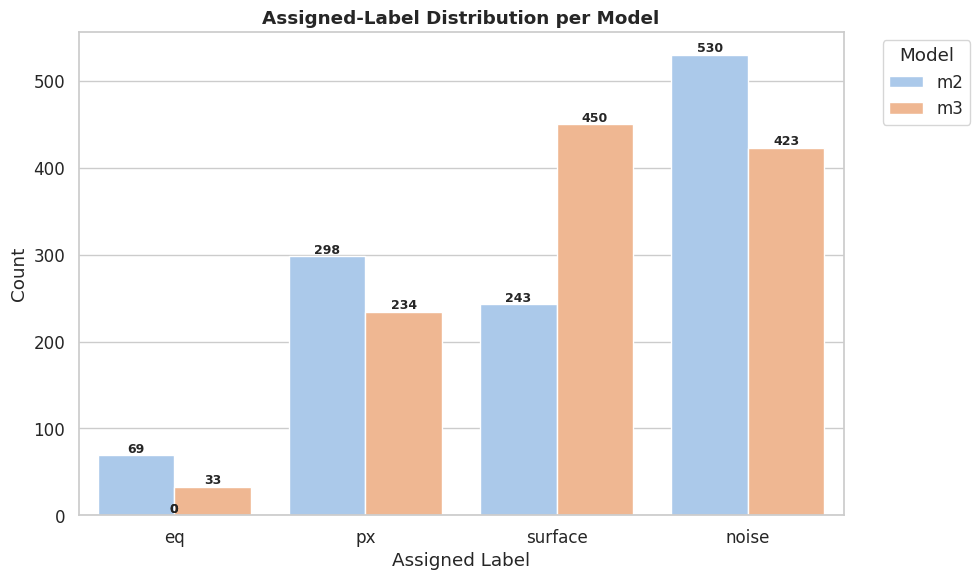

In [34]:
# ------------------------------------------------------------------
# 1.  Select the model-label columns you want to compare
# ------------------------------------------------------------------
model_cols = [
    "assigned_label_m2",
    "assigned_label_m3",
]

# ------------------------------------------------------------------
# 2.  Filter rows (SNR > 7) and reshape to long form
# ------------------------------------------------------------------
filtered = labels_df.copy()

long_df = filtered.melt(
    value_vars=model_cols,
    var_name="model",
    value_name="assigned_label"
)

# Clean model names for nicer legend labels
long_df["model"] = (
    long_df["model"]
    .str.replace("assigned_label_", "", regex=False)  # m2 → m2, ens → ens
)

# Establish a consistent label order (eq / px / surface / noise)
label_order = ["eq", "px", "surface", "noise"]

# ------------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=long_df,
    x="assigned_label",
    hue="model",
    order=label_order,
    palette="pastel"
)

# ------------------------------------------------------------------
# 4.  Annotate bar heights
# ------------------------------------------------------------------
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# ------------------------------------------------------------------
# 5.  Cosmetics
# ------------------------------------------------------------------
plt.title("Assigned-Label Distribution per Model", weight="bold")
plt.xlabel("Assigned Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Figuring out which events were mislabelled by m2 and why?

In [65]:
miss_label_m2 = labels_df[labels_df['assigned_label_m2'] == 'surface']

In [66]:
miss_label_m2

,event_id,station,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,max_prob_m3,assigned_label_m3,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens
0,276,BABIT,0.076217,0.031626,0.770184,0.121973,0.121973,surface,0.056763,0.165300,0.501111,0.276826,0.276826,surface,0.066490,0.098463,0.635647,0.199399,0.199399,surface
2,276,LG2B,0.101633,0.005865,0.575665,0.316837,0.316837,surface,0.303296,0.111114,0.468213,0.117377,0.303296,eq,0.202465,0.058490,0.521939,0.217107,0.217107,surface
5,276,X16A,0.112529,0.012008,0.613768,0.261694,0.261694,surface,0.209035,0.202274,0.246058,0.342633,0.342633,surface,0.160782,0.107141,0.429913,0.302163,0.302163,surface
18,302,IOCA,0.000817,0.016512,0.618833,0.363838,0.363838,surface,0.003660,0.031332,0.287012,0.677997,0.677997,surface,0.002238,0.023922,0.452922,0.520917,0.520917,surface
61,293,EDM,0.000141,0.014427,0.382488,0.602944,0.602944,surface,0.000992,0.188745,0.332594,0.477668,0.477668,surface,0.000567,0.101586,0.357541,0.540306,0.540306,surface
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,300,SHR,0.005469,0.108350,0.739966,0.146214,0.146214,surface,0.020439,0.068705,0.762505,0.148352,0.148352,surface,0.012954,0.088528,0.751235,0.147283,0.147283,surface
1105,297,JRO,0.029398,0.036602,0.801878,0.132122,0.132122,surface,0.007919,0.029790,0.693235,0.269056,0.269056,surface,0.018658,0.033196,0.747557,0.200589,0.200589,surface
1113,297,OPCH,0.025773,0.045493,0.736474,0.192261,0.192261,surface,0.019439,0.287600,0.423403,0.269558,0.287600,px,0.022606,0.166546,0.579938,0.230909,0.230909,surface
1137,297,YOCR,0.000834,0.000172,0.777827,0.221168,0.221168,surface,0.005707,0.014656,0.785339,0.194298,0.194298,surface,0.003270,0.007414,0.781583,0.207733,0.207733,surface


In [92]:
miss_label_m2[miss_label_m2['event_id'] == 272]

,event_id,station,prob_eq_m2,prob_px_m2,prob_noise_m2,prob_surface_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,prob_noise_m3,prob_surface_m3,max_prob_m3,assigned_label_m3,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens
94,272,BOTN,0.000814,0.043029,0.672987,0.283170,0.283170,surface,0.000963,0.219213,0.255795,0.524029,0.524029,surface,0.000889,0.131121,0.464391,0.403600,0.403600,surface
95,272,BRUN,0.003530,0.106424,0.581867,0.308179,0.308179,surface,0.000498,0.192800,0.136600,0.670101,0.670101,surface,0.002014,0.149612,0.359234,0.489140,0.489140,surface
96,272,DDAL,0.017299,0.133218,0.601697,0.247787,0.247787,surface,0.000588,0.157110,0.132279,0.710023,0.710023,surface,0.008944,0.145164,0.366988,0.478905,0.478905,surface
99,272,FJAS,0.005487,0.135100,0.589960,0.269453,0.269453,surface,0.000731,0.151640,0.088338,0.759291,0.759291,surface,0.003109,0.143370,0.339149,0.514372,0.514372,surface
100,272,FLAT,0.003187,0.054960,0.638586,0.303267,0.303267,surface,0.000918,0.315589,0.085988,0.597504,0.597504,surface,0.002053,0.185274,0.362287,0.450386,0.450386,surface
102,272,GODA,0.016043,0.166594,0.564719,0.252643,0.252643,surface,0.000608,0.184479,0.109632,0.705282,0.705282,surface,0.008325,0.175537,0.337176,0.478963,0.478963,surface
104,272,HOTT,0.016871,0.231911,0.168184,0.583034,0.583034,surface,0.000797,0.208261,0.034054,0.756888,0.756888,surface,0.008834,0.220086,0.101119,0.669961,0.669961,surface
105,272,HRIM,0.002714,0.125692,0.614016,0.257577,0.257577,surface,0.000283,0.416170,0.061550,0.521997,0.521997,surface,0.001499,0.270931,0.337783,0.389787,0.389787,surface
106,272,HRUR,0.014560,0.081781,0.659462,0.244197,0.244197,surface,0.002551,0.150482,0.099640,0.747327,0.747327,surface,0.008555,0.116132,0.379551,0.495762,0.495762,surface
107,272,HVAF,0.006735,0.109547,0.576080,0.307638,0.307638,surface,0.000258,0.245831,0.153340,0.600571,0.600571,surface,0.003497,0.177689,0.364710,0.454104,0.454104,surface


In [75]:
np.unique(miss_label_m2['event_id'].values, return_counts = True)

(array([134, 264, 272, 276, 283, 284, 286, 287, 289, 290, 293, 294, 297,
        298, 300, 301, 302, 303, 304, 305, 306, 307, 309, 310, 319, 320,
        321, 324, 326, 328, 329, 331, 332]),
 array([ 2,  4, 23,  3,  2,  5,  2,  1,  7,  5,  7,  3,  3,  5,  1, 47,  1,
         3, 15,  2, 21,  8,  4,  8,  1,  4, 10, 25,  1,  5,  6,  1,  8]))

## Plotting the waveforms to see what is going on

In [93]:
cat[cat['eventid'] == 272]['starttime']

9    2014_07_21 232404
Name: starttime, dtype: object

In [55]:
st

3 Trace(s) in Stream:
UO.GROV..HHE | 2023-04-24T16:18:05.000000Z - 2023-04-24T16:24:45.000000Z | 100.0 Hz, 40001 samples
UO.GROV..HHN | 2023-04-24T16:18:05.000000Z - 2023-04-24T16:24:45.000000Z | 100.0 Hz, 40001 samples
UO.GROV..HHZ | 2023-04-24T16:18:05.000000Z - 2023-04-24T16:24:45.000000Z | 100.0 Hz, 40001 samples

In [6]:
start = '2014-07-21T23:24:04'
starttime = obspy.UTCDateTime(start) - 200
endtime = obspy.UTCDateTime(start) + 200
network = '*'
station = 'BOTN'
channel = '*H*'
loc = '*'

client = Client('IRIS')
st = client.get_waveforms(starttime = starttime, 
                    endtime = endtime, 
                    network = network, 
                    station = station, 
                    channel = channel, 
                    location = loc)

In [7]:
st

3 Trace(s) in Stream:
Z7.BOTN..HHE | 2014-07-21T23:20:44.000000Z - 2014-07-21T23:27:24.000000Z | 100.0 Hz, 40001 samples
Z7.BOTN..HHN | 2014-07-21T23:20:44.000000Z - 2014-07-21T23:27:24.000000Z | 100.0 Hz, 40001 samples
Z7.BOTN..HHZ | 2014-07-21T23:20:44.000000Z - 2014-07-21T23:27:24.000000Z | 100.0 Hz, 40001 samples

In [8]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")

model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')
model4 = sbm.SeismicCNN.from_pretrained("base", version_str = '4')
model5 = sbm.SeismicCNN.from_pretrained("base", version_str = '5')
model6 = sbm.SeismicCNN.from_pretrained("base", version_str = '6')

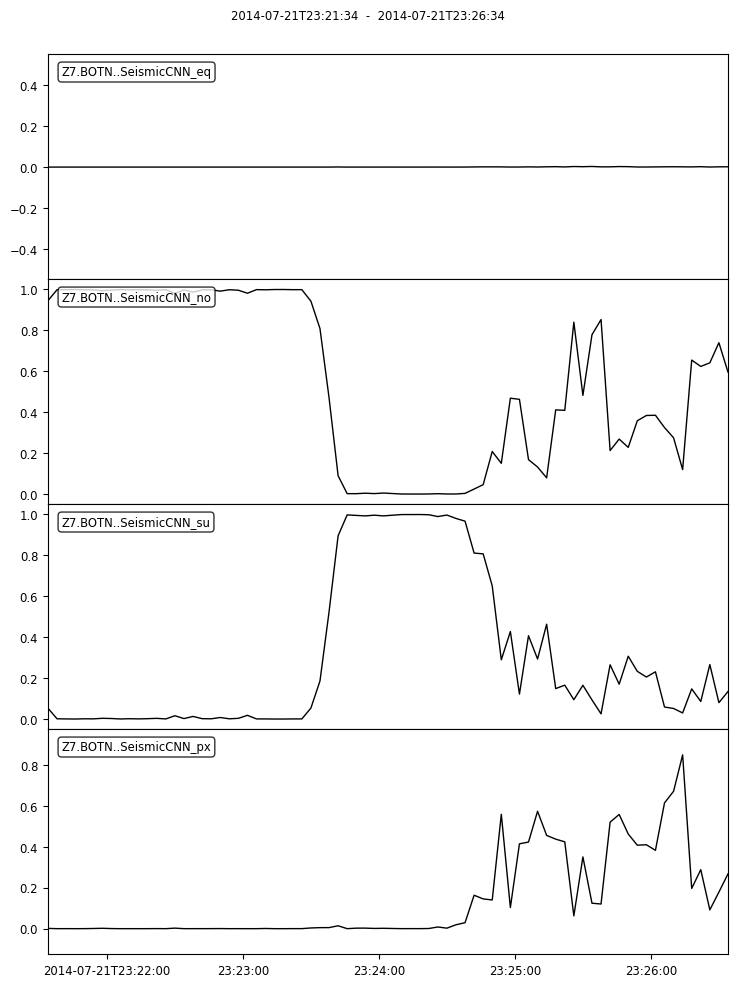

In [9]:
model3.annotate(st, stride = 200).plot();

In [19]:
probs = np.array(model3.annotate(st, stride = 200))
probs_st = model3.annotate(st, stride = 200)

In [21]:
probs_st[0].times()

array([  0.,   4.,   8.,  12.,  16.,  20.,  24.,  28.,  32.,  36.,  40.,
        44.,  48.,  52.,  56.,  60.,  64.,  68.,  72.,  76.,  80.,  84.,
        88.,  92.,  96., 100., 104., 108., 112., 116., 120., 124., 128.,
       132., 136., 140., 144., 148., 152., 156., 160., 164., 168., 172.,
       176., 180., 184., 188., 192., 196., 200., 204., 208., 212., 216.,
       220., 224., 228., 232., 236., 240., 244., 248., 252., 256., 260.,
       264., 268., 272., 276., 280., 284., 288., 292., 296., 300.])

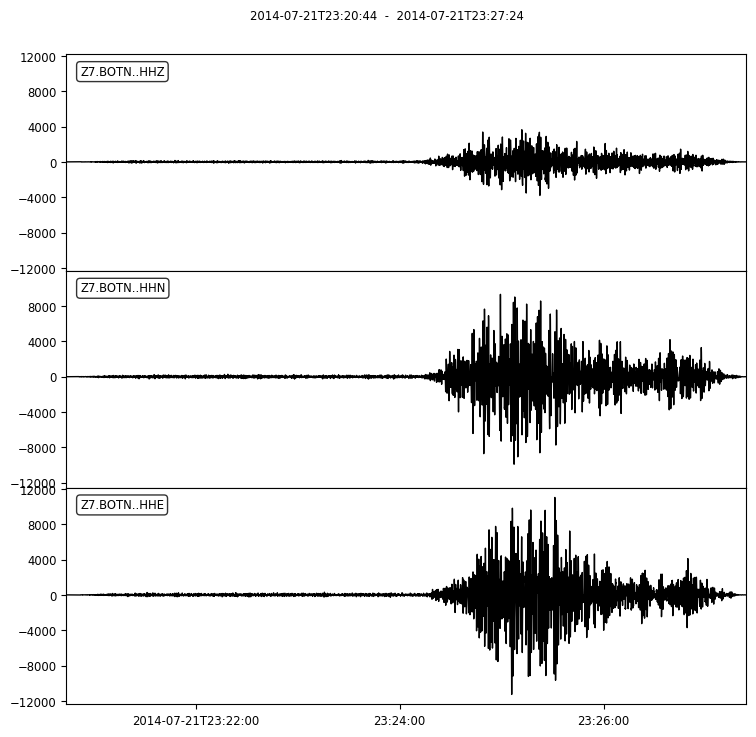

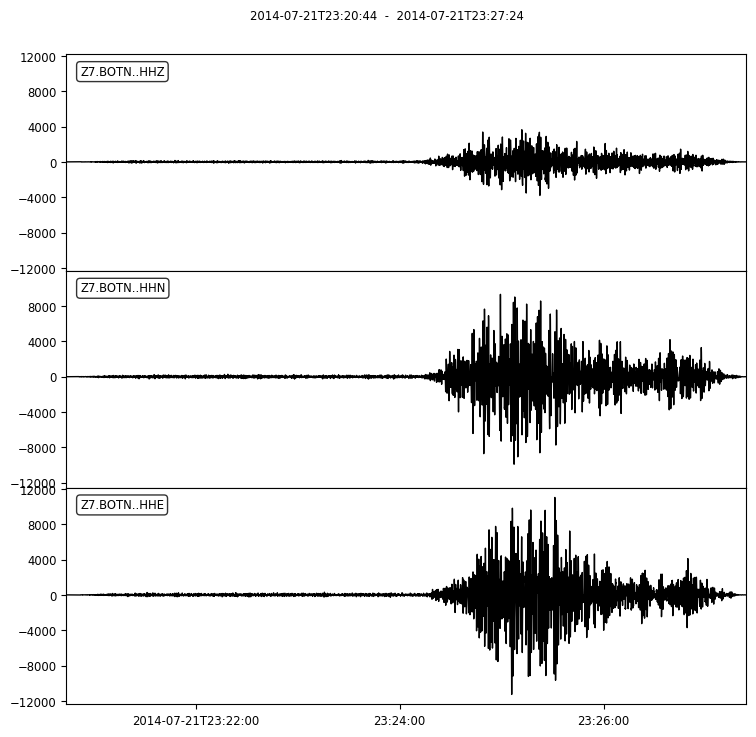

In [10]:
st.detrend('linear')
st.taper(0.1)
st.filter('bandpass', freqmin = 1, freqmax = 10)
st.plot()

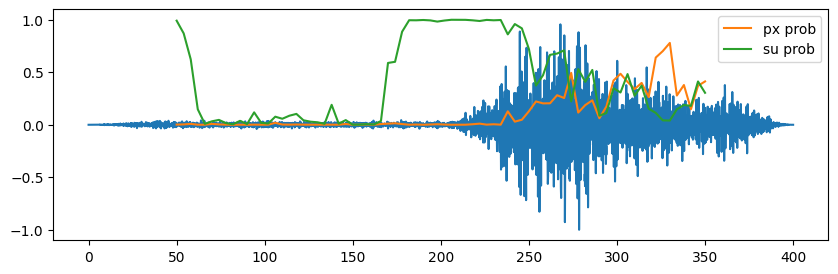

In [33]:
plt.figure(figsize = [10,3])
times_st = st[2].times()
plt.plot(times_st, st[2].data/max(abs(st[2].data)))


# probs_st = stream of probabilities
# this is going to be the same regardless
times = probs_st[2].times()
#plt.plot(times+50, probs[0])
plt.plot(times+50, probs[1], label = 'px prob')
#plt.plot(times+50, probs[2])
plt.plot(times+50, probs[3], label = 'su prob')
plt.legend()

In [82]:
event_id = 307
station = 'A060B'
files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*")
st = []

for file in files:
    st += obspy.read(file)
    
st = obspy.Stream(st)

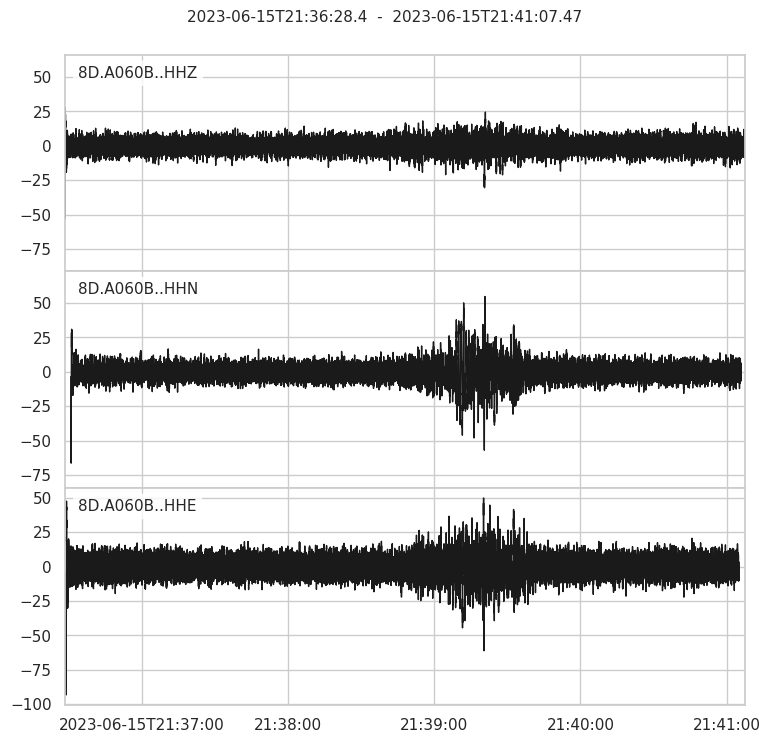

In [83]:
st.detrend('linear')
st.filter('bandpass', freqmin = 1, freqmax = 20)
st.plot();

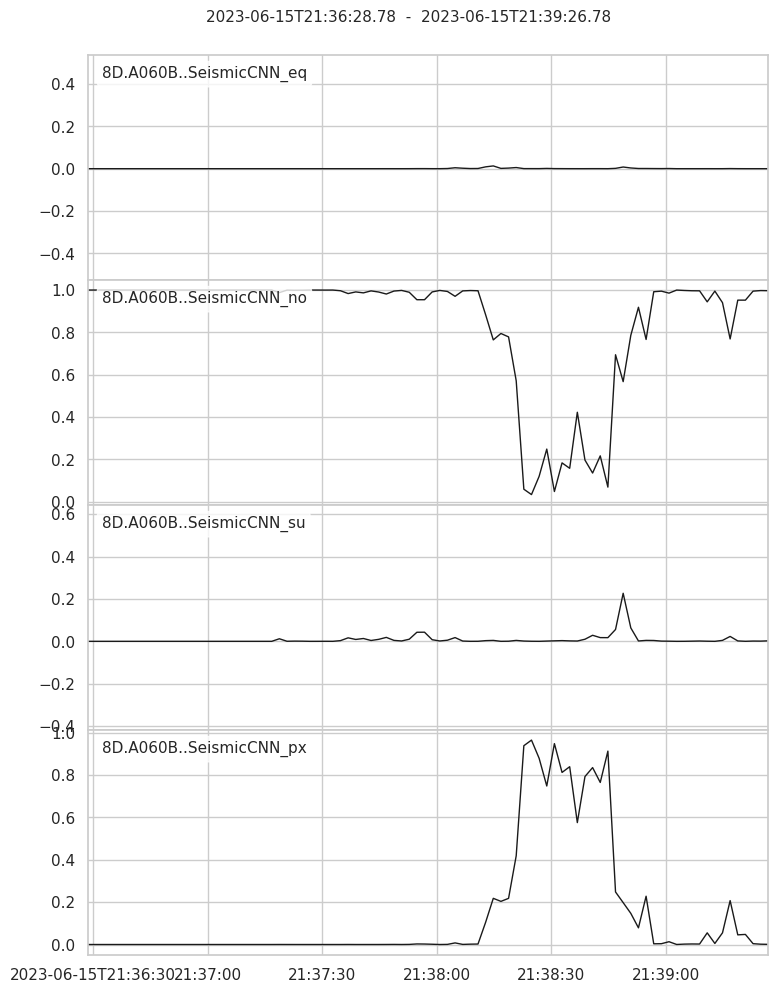

In [84]:
model2.annotate(st, stride = 100).plot();

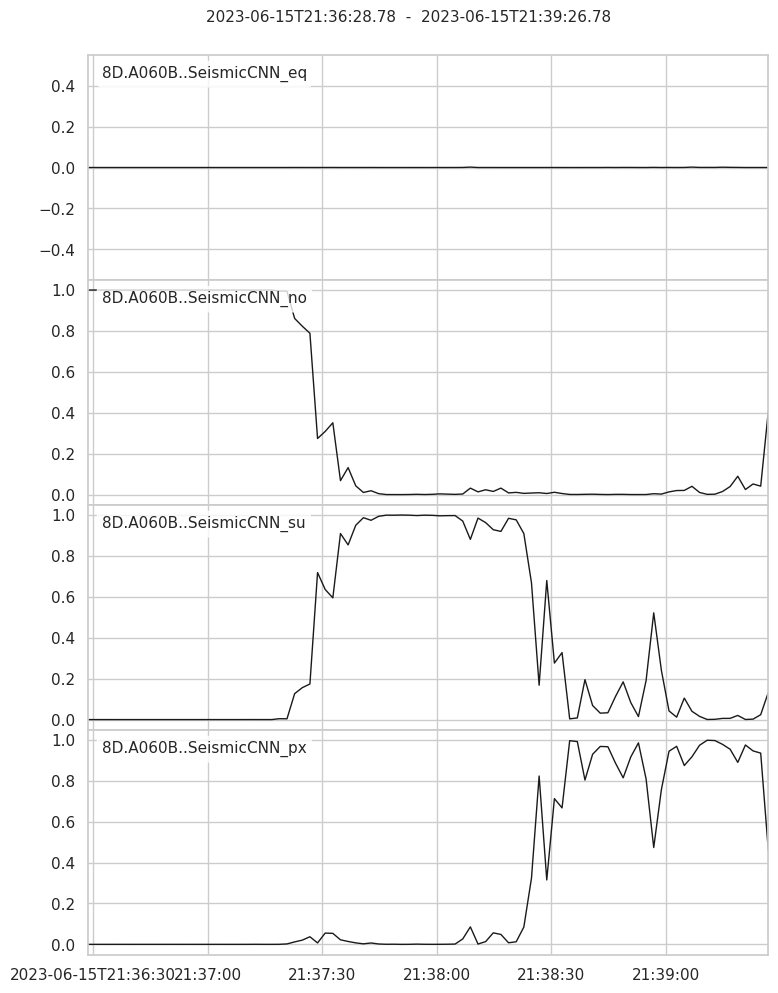

In [85]:
model3.annotate(st, stride = 100).plot();

In [68]:
st

3 Trace(s) in Stream:
C8.HWKB..HHE | 2022-09-01T18:02:05.000000Z - 2022-09-01T18:06:35.000000Z | 100.0 Hz, 27001 samples
C8.HWKB..HHN | 2022-09-01T18:02:05.000000Z - 2022-09-01T18:06:35.000000Z | 100.0 Hz, 27001 samples
C8.HWKB..HHZ | 2022-09-01T18:02:05.000000Z - 2022-09-01T18:06:35.000000Z | 100.0 Hz, 27001 samples

In [17]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()
print(len(labels_df))

1140


In [18]:
labels_df.to_csv('../seisbench_output/esec_event_output_labels_from_retrained_model.csv')

In [19]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
#for i in tqdm(range(100, 150)):    
    event_id = labels_df['event_id'].values[i]
    station = labels_df['station'].values[i]
    files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HN*')
    tr = obspy.read(files[0])
    tr.resample(50)
    tr.detrend('linear')
    tr.taper(0.05)
    tr.filter('bandpass', freqmin = 1, freqmax = 20)

    #plot_trace(tr)
    #print(label)
    # snr - signal to noise ratio
    d = tr[0].data
    
    #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
    #print(snr)
    
    snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    
labels_df['snr_n'] = snr

100%|██████████| 1140/1140 [00:07<00:00, 156.37it/s]


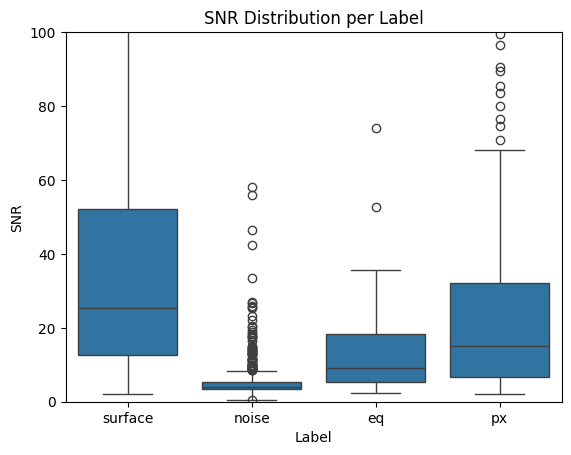

In [22]:
sns.boxplot(data=labels_df, x="assigned_label_m2", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,100)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


In [26]:
good_df_m3 = labels_df[labels_df['assigned_label_m3'] == 'surface']

In [27]:
good_df_m3

,event_id,station,prob_eq_m2,prob_px_m2,max_prob_m2,assigned_label_m2,prob_eq_m3,prob_px_m3,max_prob_m3,assigned_label_m3,prob_eq_m5,prob_px_m5,max_prob_m5,assigned_label_m5,prob_eq_m6,prob_px_m6,max_prob_m6,assigned_label_m6,prob_eq_ens,prob_px_ens,prob_noise_ens,prob_surface_ens,max_prob_ens,assigned_label_ens,snr_n
1,276,BARN,0.133080,0.003457,0.133080,noise,0.426349,0.498116,0.987628,surface,0.935541,0.007220,0.935541,eq,0.024026,0.000798,0.788889,surface,0.379749,0.127398,0.766570,0.488522,0.488522,noise,5.314800
5,276,X16A,0.631416,0.012331,0.631416,eq,0.590087,0.226117,0.770656,surface,0.898316,0.029712,0.999999,surface,0.014107,0.021862,0.997037,surface,0.533482,0.072506,0.830035,0.777844,0.777844,surface,2.506837
18,302,IOCA,0.005063,0.023275,0.995776,surface,0.002697,0.003744,0.993032,surface,0.002730,0.007219,0.997510,surface,0.022520,0.073450,0.987576,surface,0.008252,0.026922,0.777311,0.993474,0.993474,surface,61.584441
29,302,OT11,0.250966,0.042083,0.621105,surface,0.060690,0.167862,0.697483,surface,0.088572,0.016644,0.882187,surface,0.060926,0.019604,0.808599,surface,0.115289,0.061548,0.939619,0.752343,0.752343,surface,7.143614
37,302,PTRJ,0.009711,0.055840,0.055840,noise,0.014500,0.059735,0.660393,surface,0.012652,0.663295,0.663295,px,0.008140,0.018227,0.804199,surface,0.011251,0.199274,0.976469,0.398540,0.398540,noise,2.268995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,300,SHR,0.000037,0.001411,0.927665,surface,0.006377,0.068577,0.560666,surface,0.000081,0.204513,0.358280,noise,0.000830,0.006154,0.772973,surface,0.001831,0.070164,0.996510,0.654896,0.654896,surface,5.101383
1094,297,ARTIC,0.002036,0.417464,0.417464,noise,0.000806,0.271066,0.717810,surface,0.002845,0.326965,0.646275,surface,0.017497,0.287589,0.666570,surface,0.005796,0.325771,0.973862,0.515095,0.515095,surface,7.079201
1102,297,GRSDL,0.008346,0.026806,0.026806,noise,0.000779,0.529755,0.596699,surface,0.003247,0.000178,0.023071,noise,0.006803,0.001130,0.850595,surface,0.004794,0.139468,0.998334,0.371804,0.371804,noise,3.761869
1110,297,MONKS,0.954852,0.498697,0.954852,eq,0.922119,0.934555,0.976925,surface,0.837645,0.103468,0.837645,eq,0.897535,0.190608,0.897535,eq,0.903038,0.431832,0.122803,0.720307,0.903038,eq,16.492661


In [36]:
probs_global[302, 'IOCA']

{'m2': array([[3.8949370e-06, 5.0633545e-03, 3.0989712e-04, 1.5102528e-03],
        [2.9246761e-05, 2.1857582e-02, 3.3590591e-03, 2.3274504e-02],
        [7.8830528e-01, 3.6278948e-01, 5.5531564e-04, 9.5510978e-01],
        [2.1166152e-01, 6.1028963e-01, 9.9577576e-01, 2.0105507e-02]],
       dtype=float32),
 'm3': array([[2.7238918e-03, 2.4742153e-04, 1.3379635e-05, 2.6966170e-03],
        [8.8393914e-05, 3.7444506e-03, 2.6204276e-03, 1.3856547e-03],
        [7.1833676e-01, 1.3251302e-01, 4.3339813e-03, 8.5359699e-01],
        [2.7885100e-01, 8.6349511e-01, 9.9303222e-01, 1.4232078e-01]],
       dtype=float32),
 'm5': array([[2.1916637e-04, 2.6362583e-03, 1.7890627e-04, 2.7301728e-03],
        [2.2349990e-04, 1.7690434e-04, 2.2260712e-03, 7.2191344e-03],
        [2.8574255e-01, 3.1421271e-03, 8.4609339e-05, 6.4091402e-01],
        [7.1381480e-01, 9.9404472e-01, 9.9751043e-01, 3.4913668e-01]],
       dtype=float32),
 'm6': array([[6.9041867e-08, 3.7612566e-03, 2.2537452e-03, 2.2519577e

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------
# 1.  Select the model-label columns you want to compare
# ------------------------------------------------------------------
model_cols = [
    "assigned_label_m2",
    "assigned_label_m3",
    "assigned_label_ens",   # ensemble-mean
    "assigned_label_m5",    # add/remove as needed
    "assigned_label_m6"
]

# ------------------------------------------------------------------
# 2.  Filter rows (SNR > 7) and reshape to long form
# ------------------------------------------------------------------
filtered = labels_df[labels_df["snr_n"] > 7].copy()

long_df = filtered.melt(
    value_vars=model_cols,
    var_name="model",
    value_name="assigned_label"
)

# Clean model names for nicer legend labels
long_df["model"] = (
    long_df["model"]
    .str.replace("assigned_label_", "", regex=False)  # m2 → m2, ens → ens
)

# Establish a consistent label order (eq / px / surface / noise)
label_order = ["eq", "px", "surface", "noise"]

# ------------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=long_df,
    x="assigned_label",
    hue="model",
    order=label_order,
    palette="pastel"
)

# ------------------------------------------------------------------
# 4.  Annotate bar heights
# ------------------------------------------------------------------
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# ------------------------------------------------------------------
# 5.  Cosmetics
# ------------------------------------------------------------------
plt.title("Assigned-Label Distribution per Model (SNR > 7)", weight="bold")
plt.xlabel("Assigned Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


KeyError: 'snr_n'

In [32]:
good_df  = labels_df[labels_df['snr_n'] > 7]
mean_probs = good_df.groupby('event_id')[['prob_eq', 'prob_px', 'prob_surface']].mean()

# Step 2: Identify the label with the highest mean probability (excluding noise)
mean_probs['event_label'] = mean_probs.idxmax(axis=1).str.replace('prob_', '')

# Optional: merge back into original DataFrame if needed
good_df = good_df.merge(mean_probs['event_label'], on='event_id', how='left')

KeyError: "Columns not found: 'prob_surface', 'prob_eq', 'prob_px'"

In [33]:
plt.figure(figsize=(8, 5))
sns.countplot(data=mean_probs, x='event_label', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


NameError: name 'mean_probs' is not defined

<Figure size 800x500 with 0 Axes>

In [33]:
good_df

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label,snr_n,event_label
0,276,PRCT,8.543427e-01,0.108253,0.992975,0.039274,0.854343,eq,12.516802,eq
1,276,U15A,1.003786e-04,0.000322,0.999996,0.000197,0.000322,noise,8.077343,eq
2,302,CERA,1.921099e-07,0.000001,0.999999,0.000006,0.000006,noise,7.659795,surface
3,302,IOCA,5.063355e-03,0.023275,0.955110,0.995776,0.995776,surface,61.584441,surface
4,302,OT11,2.509664e-01,0.042083,0.999997,0.621105,0.621105,surface,7.143614,surface
...,...,...,...,...,...,...,...,...,...,...
476,297,BOIS,9.270422e-02,0.731575,0.962852,0.165847,0.731575,px,10.218303,eq
477,297,KUHN,9.997645e-01,0.812830,0.999990,0.008474,0.999765,eq,23.656638,eq
478,297,MONKS,9.548517e-01,0.498697,0.981633,0.356169,0.954852,eq,16.492661,eq
479,297,NBFR,6.577789e-01,0.979918,0.990219,0.009419,0.979918,px,99.412314,eq


In [28]:
def plot_event_waveforms(event_id, labels_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/'):
    # Filter rows for this event
    subset = labels_df[labels_df['event_id'] == event_id]
    
    event_type = cat[cat['eventid'] == event_id]['type'].values[0]
    if subset.empty:
        print(f"No data found for event {event_id}")
        return
    
    # Get event-level label from the first row
    event_label = subset['event_label'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 1.8 * len(subset)))
    
    for idx, row in subset.iterrows():
        station = row['station']
        
        # Find the vertical-component HZ file
        files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HZ*')
        if not files:
            print(f"No HZ component found for {station} in event {event_id}")
            continue
        
        try:
            tr = obspy.read(files[0])[0]
            tr.resample(50)
            tr.detrend('linear')
            tr.taper(0.05)
            tr.filter('bandpass', freqmin=1, freqmax=20)
            data = tr.data
            times = np.arange(len(data)) / tr.stats.sampling_rate

            # Offset the waveform vertically
            offset = idx
            ax.plot(times, data / np.max(np.abs(data)) + offset, lw=0.8, color='steelblue')

            # Format the label with probabilities
            prob_text = f"{station} | eq:{row['prob_eq']:.2f} px:{row['prob_px']:.2f} su:{row['prob_surface']:.2f}"
            ax.text(times[-1] + 2, offset, prob_text, va='center', fontsize=8)

        except Exception as e:
            print(f"Error loading {station} for event {event_id}: {e}")
            continue
    
    ax.set_title(f"Event {event_id} | Label: {event_label.upper()} | Event Type: {event_type}", fontsize=14, weight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])  # Remove numerical ticks; we use text annotations
    ax.set_ylabel("Stations (vertical offset)")
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Ensure save directory exists
    os.makedirs(savepath, exist_ok=True)
    # Now save
    plt.savefig(os.path.join(savepath, f'{event_id}_from_retrained.png'))
    
    plt.close()

In [29]:
eq_df = mean_probs[mean_probs['event_label'] == 'eq']
px_df = mean_probs[mean_probs['event_label'] == 'px']
su_df = mean_probs[mean_probs['event_label'] == 'surface']

In [30]:
event_ids = eq_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/')

    
event_ids = px_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/explosion/')

    
event_ids = su_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/surface/')